# Perform cross-integration of Levine and Stuart

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import cytovi
from scib_metrics.nearest_neighbors import pynndescent as scib_pynndescent
from scib_metrics import ilisi_knn

/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/utils.py:434: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/projects/amit/fl

In [2]:
os.chdir('/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/notebooks/')
figure_dir = '../figures/figure4/'

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams["savefig.dpi"] = 300

sc.settings.figdir = figure_dir
sc.set_figure_params(dpi_save = 300)
sc.settings.n_jobs = 40

In [129]:
def save_adata_as_csv(adata, path_prefix, adata_name, layer_key):
    adata_str = adata_name.replace('.h5ad', '')
    adata.obs.to_csv(f'{path_prefix}/{adata_str}_obs.csv')
    expr_df = pd.DataFrame(adata.layers[layer_key], columns=adata.var_names)
    expr_df.to_csv(f'{path_prefix}/{adata_str}_expr.csv')

EPS = 1e-9

def _find_ablation(obs, batch_col='batch', ct_col='cell_type'):
    tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)
    miss = np.argwhere(tab.values == 0)
    if miss.size == 0:
        raise ValueError("No ablated (cell_type, batch) pair found.")
    i, j = miss[0]
    return tab.index[i], tab.columns[j], tab

def _xbn_fraction_nn(X, batches, idx, k=10):
    """Cross-batch neighbor fraction for a query set (excludes self)."""
    from sklearn.neighbors import NearestNeighbors
    if len(idx) == 0:
        return np.nan
    k_eff = min(k + 1, X.shape[0])
    nn = NearestNeighbors(n_neighbors=k_eff, metric='euclidean').fit(X)
    neigh = nn.kneighbors(X[idx], return_distance=False)
    neigh = neigh[:, 1:k+1] if neigh.shape[1] > k else neigh[:, :k]
    return float((batches[neigh] != batches[idx][:, None]).mean())

def _ilisi_shared_scib(X, batches, idx_shared, k_ilisi=30):
    """Mean scaled iLISI on shared cells using scib-metrics (neighbors built on the subset)."""
    if len(idx_shared) == 0:
        return np.nan
    Xs = X[idx_shared]
    bs = batches[idx_shared]
    # Build neighbors that the metric expects (NeighborsResults)
    nn_results = scib_pynndescent(Xs, n_neighbors=k_ilisi)  # returns NeighborsResults
    # Scaled iLISI in [0,1]; higher = more batch mixing on shared types
    return float(ilisi_knn(nn_results, bs, scale=True))      # iLISI (mean) from scib-metrics

def evaluate_integration_scib_ilisi(
    adata, emb_keys,
    batch_col='batch',
    ct_col='cell_type',
    unint_key='X_unintegrated',
    k_leak=10, k_ilisi=30
):
    """Leakage vs. shared-type mixing (iLISI from scib-metrics)."""
    B = adata.obs[batch_col].astype(str).to_numpy()
    C = adata.obs[ct_col].astype(str).to_numpy()

    missing_ct, missing_batch, tab = _find_ablation(adata.obs, batch_col, ct_col)
    existing_batch = [b for b in np.unique(B) if b != missing_batch][0]
    shared_types = tab.index[(tab > 0).all(axis=1)].to_numpy()

    # index sets
    idx_ct = np.where((C == missing_ct) & (B == existing_batch))[0]                 # ablated target
    idx_ctrl = np.where(np.isin(C, shared_types) & (B == existing_batch))[0]        # control (shared, same batch)
    idx_shared_all = np.where(np.isin(C, shared_types))[0]                          # for iLISI_shared

    # Baseline (unintegrated)
    X_base = np.asarray(adata.obsm[unint_key], dtype=np.float32)
    xbn_ct_base   = _xbn_fraction_nn(X_base, B, idx_ct,   k=k_leak)
    xbn_ctrl_base = _xbn_fraction_nn(X_base, B, idx_ctrl, k=k_leak)
    ratio_base    = xbn_ct_base / max(xbn_ctrl_base, EPS)
    logratio_base = np.log((xbn_ct_base + EPS) / (xbn_ctrl_base + EPS))
    ilisi_base    = _ilisi_shared_scib(X_base, B, idx_shared_all, k_ilisi=k_ilisi)

    rows = []
    for rep_key in emb_keys:
        X = np.asarray(adata.obsm[rep_key], dtype=np.float32)

        # Leakage around ablated type
        xbn_ct   = _xbn_fraction_nn(X, B, idx_ct,   k=k_leak)
        xbn_ctrl = _xbn_fraction_nn(X, B, idx_ctrl, k=k_leak)
        ratio    = xbn_ct / max(xbn_ctrl, EPS)
        logratio = np.log((xbn_ct + EPS) / (xbn_ctrl + EPS))

        # Mixing on shared types (scib-metrics iLISI)
        ilisi = _ilisi_shared_scib(X, B, idx_shared_all, k_ilisi=k_ilisi)

        # Deltas vs. unintegrated
        d_ilisi    = ilisi - ilisi_base  
        d_logratio = logratio - logratio_base   
        net_score  = d_ilisi - d_logratio      

        rows.append({
            'embedding': rep_key,
            'missing_ct': missing_ct,
            'missing_batch': missing_batch,
            'existing_batch': existing_batch,
            'k_leak': k_leak,
            'k_ilisi': k_ilisi,
            'XBN_ct': xbn_ct,
            'XBN_ctrl': xbn_ctrl,
            'XBN_ratio': ratio,
            'XBN_logratio': logratio,
            'iLISI_shared_scaled': ilisi,
            'diLISI_shared_scaled': d_ilisi,
            'dlog_XBN_ratio': d_logratio,
            'NetScore': net_score
        })
    return pd.DataFrame(rows)


In [5]:
# construct an AnnData object from the Levine dataset
data_dir = '/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/raw/CyTOF/Levine'

expr = pd.read_csv(os.path.join(data_dir, 'Levine_32dim_notransform_expr.csv'))
obs = pd.read_csv(os.path.join(data_dir, 'Levine_32dim_notransform_obs.csv'))

adata_cytof = ad.AnnData(X=expr, obs=obs, var=pd.DataFrame(index=expr.columns))
adata_cytof.layers['raw'] = adata_cytof.X.copy()

cytovi.pp.arcsinh(adata_cytof)
cytovi.pp.scale(adata_cytof)

/tmp/ipykernel_1398/4283533053.py:5: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  obs = pd.read_csv(os.path.join(data_dir, 'Levine_32dim_notransform_obs.csv'))
/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
# select only annotated cells of one donor
adata_cytof = adata_cytof[~adata_cytof.obs['population'].isna()].copy()
adata_cytof = adata_cytof[adata_cytof.obs['individual']==2].copy()

In [7]:
# assemble anndata for CITEseq
data_dir_cite = '/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/data/raw/CITE_seq/bmcite/'

expr_cite = pd.read_csv(os.path.join(data_dir_cite, 'bmcite_ADT_counts.csv'), index_col=0).T
obs_cite = pd.read_csv(os.path.join(data_dir_cite, 'bmcite_obs.csv'), index_col=0)

adata_cite = ad.AnnData(X=expr_cite, obs=obs_cite, var=pd.DataFrame(index=expr_cite.columns))
adata_cite.layers['raw'] = adata_cite.X.copy()

cytovi.pp.arcsinh(adata_cite)
cytovi.pp.scale(adata_cite)

# rename cols
adata_cite.var_names = adata_cite.var_names.str.replace('HLA.DR', 'HLA-DR')
adata_cite.var_names = adata_cite.var_names.str.replace('CD8a', 'CD8')

In [8]:
map_cite = {
    "Prog_RBC": "HSPC",
    "gdT": "Unknown",               
    "CD4 Naive": "T_CD4",
    "CD4 Memory": "T_CD4",
    "CD14 Mono": "Monocytes",
    "Naive B": "B_cell_mature",
    "CD8 Naive": "T_CD8",
    "Treg": "T_CD4",           
    "CD8 Effector_2": "T_CD8",
    "NK": "NK",
    "GMP": "HSPC",
    "CD8 Effector_1": "T_CD8",
    "CD16 Mono": "Monocytes",
    "pDC": "pDC",
    "CD8 Memory_1": "T_CD8",
    "MAIT": "Unknown",           
    "Memory B": "B_cell_mature",
    "cDC2": "Unknown",              
    "CD56 bright NK": "NK",
    "Prog_B 2": "B_cell_progenitor",
    "Prog_Mk": "HSPC",
    "CD8 Memory_2": "T_CD8",
    "Plasmablast": "Plasma_B",
    "HSC": "HSC",
    "LMPP": "HSPC",
    "Prog_DC": "HSPC",
    "Prog_B 1": "B_cell_progenitor",
}


map_cytof = {
    "Basophils": "Unknown",     
    "CD16-_NK_cells": "NK",       
    "CD16+_NK_cells": "NK",
    "CD34+CD38+CD123-_HSPCs": "HSPC", 
    "CD34+CD38+CD123+_HSPCs": "HSPC",
    "CD34+CD38lo_HSCs": "HSC",
    "CD4_T_cells": "T_CD4",
    "CD8_T_cells": "T_CD8",
    "Mature_B_cells": "B_cell_mature",
    "Monocytes": "Monocytes",
    "pDCs": "pDC",
    "Plasma_B_cells": "Plasma_B",
    "Pre_B_cells": "B_cell_progenitor",
    "Pro_B_cells": "B_cell_progenitor",
}

adata_cite.obs['harmonized_labels'] = adata_cite.obs['celltype.l2'].map(map_cite).fillna('Unknown')
adata_cytof.obs['harmonized_labels'] = adata_cytof.obs['population'].map(map_cytof).fillna('Unknown')

## export datasets

In [ ]:
model_path = '/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/models/cross_tech_int/2025-08-20_Levine_Stuart'

adata = cytovi.pp.merge_batches([adata_cite, adata_cytof])

# std scale
cytovi.pp.scale(adata, batch_key='batch', method='standard', scaled_layer_key='std_scaled')
adata.layers['std_scaled'] = np.nan_to_num(adata.layers['std_scaled'], nan=0.0)

# adata.write(f'{model_path}/2025-08-20_Levine_Stuart_combined_adata.h5ad')

In [12]:
# save expr and obs for R-based methods
bb_markers = adata.var_names[adata.var.all(axis=1)]
adata_bb = adata[:, bb_markers].copy()
save_adata_as_csv(adata_bb, model_path, '2025-08-20_Levine_Stuart_combined_adata.h5ad', 'std_scaled')

# save transformed expression for Cycombine
expr_trans = pd.DataFrame(adata_bb.layers['transformed'], columns=adata_bb.var_names)
expr_trans.to_csv(f'{model_path}/2025-08-20_Levine_Stuart_combined_adata_transformed_expr.csv')

In [10]:
# read the embds
adata = ad.read_h5ad(f'{model_path}/2025-08-20_Levine_Stuart_combined_adata_cytovi_harmony.h5ad')

In [13]:
# add embeddings from FastMNN
adata.obsm['X_FastMNN'] = pd.read_csv(f'{model_path}/2025-08-20_Levine_Stuart_combined_adata_FastMNN.csv').to_numpy()
adata.obsm['X_Cycombine'] = pd.read_csv(f'{model_path}/2025-08-20_Levine_Stuart_combined_adata_Cycombine.csv').to_numpy()
adata.obsm['X_Cycombine_rank'] = pd.read_csv(f'{model_path}/2025-08-20_Levine_Stuart_combined_adata_Cycombine_rank.csv').to_numpy()
adata.obsm['X_unintegrated'] = adata_bb.layers['std_scaled'].copy()

In [31]:
# save anndata
adata.write(f'{model_path}/2025-08-21_Levine_Stuart_combined_adata_all_methods.h5ad')

In [4]:
# read again
adata = ad.read_h5ad(f'{model_path}/2025-08-21_Levine_Stuart_combined_adata_all_methods.h5ad')

In [23]:
sc.pp.neighbors(adata, use_rep='X_unintegrated')
sc.tl.umap(adata)

In [ ]:
# plot
label_colors = {
    'B_cell_mature':   '#6492CC', 
    'B_cell_progenitor': '#9BB8E3', 
    'Plasma_B':        '#4F7BBE',  
    'T_CD4':           '#DD5126', 
    'T_CD8':           '#F6B319',
    'Monocytes':       '#00A9B8',  
    'NK':              '#3A528A', 
    'pDC':             '#56C09F', 
    'HSC':             '#F6B319', 
    'HSPC':            '#DEAE5E',
    'Unknown':         'lightgrey'
}

batch_colors = ['#00A9B8', '#F6B319']

sc.pl.umap(adata, color = 'harmonized_labels', palette=label_colors)
sc.pl.umap(adata, color = 'batch', palette= batch_colors)

In [27]:
latent_obsm_keys = [*adata.obsm.keys()]

for key in latent_obsm_keys:
    sc.pp.neighbors(adata, use_rep=key)
    sc.tl.umap(adata)
    adata.obsm[f"X_umap_{key[2:]}"] = adata.obsm['X_umap'].copy()

In [ ]:
for key in latent_obsm_keys:
    sc.pl.embedding(adata, basis =  f'X_umap_{key[2:]}', color = ['batch', 'harmonized_labels'], frameon=False, save = f'embedding_cross_int_{key[2:]}.png')

## Scib

In [68]:
# perform scib
adata_bm = adata[adata.obs['harmonized_labels'] != 'Unknown', bb_markers].copy()
adata_bm.obs['harmonized_labels'].cat.remove_unused_categories()

adata_bm = cytovi.pp.subsample(adata_bm, n_obs = 20000, groupby = 'batch').copy()
adata_bm.X = adata_bm.layers['std_scaled'].copy()

/home/projects/amit/floriani/github_repos/CytoVI_dev/src/cytovi/pp/cyto_pp.py:355: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index = adata.obs.groupby(groupby, as_index=False).apply(


In [ ]:
# perform the actual benchmarking
from scib_metrics.benchmark import Benchmarker, BioConservation

biocon = BioConservation(nmi_ari_cluster_labels_leiden = True, nmi_ari_cluster_labels_kmeans = False)

bm = Benchmarker(
    adata_bm,
    batch_key="batch",
    label_key="harmonized_labels",
    embedding_obsm_keys=latent_obsm_keys,
    pre_integrated_embedding_obsm_key='X_unintegrated',
    bio_conservation_metrics = biocon,
    n_jobs=40,
)
bm.benchmark()

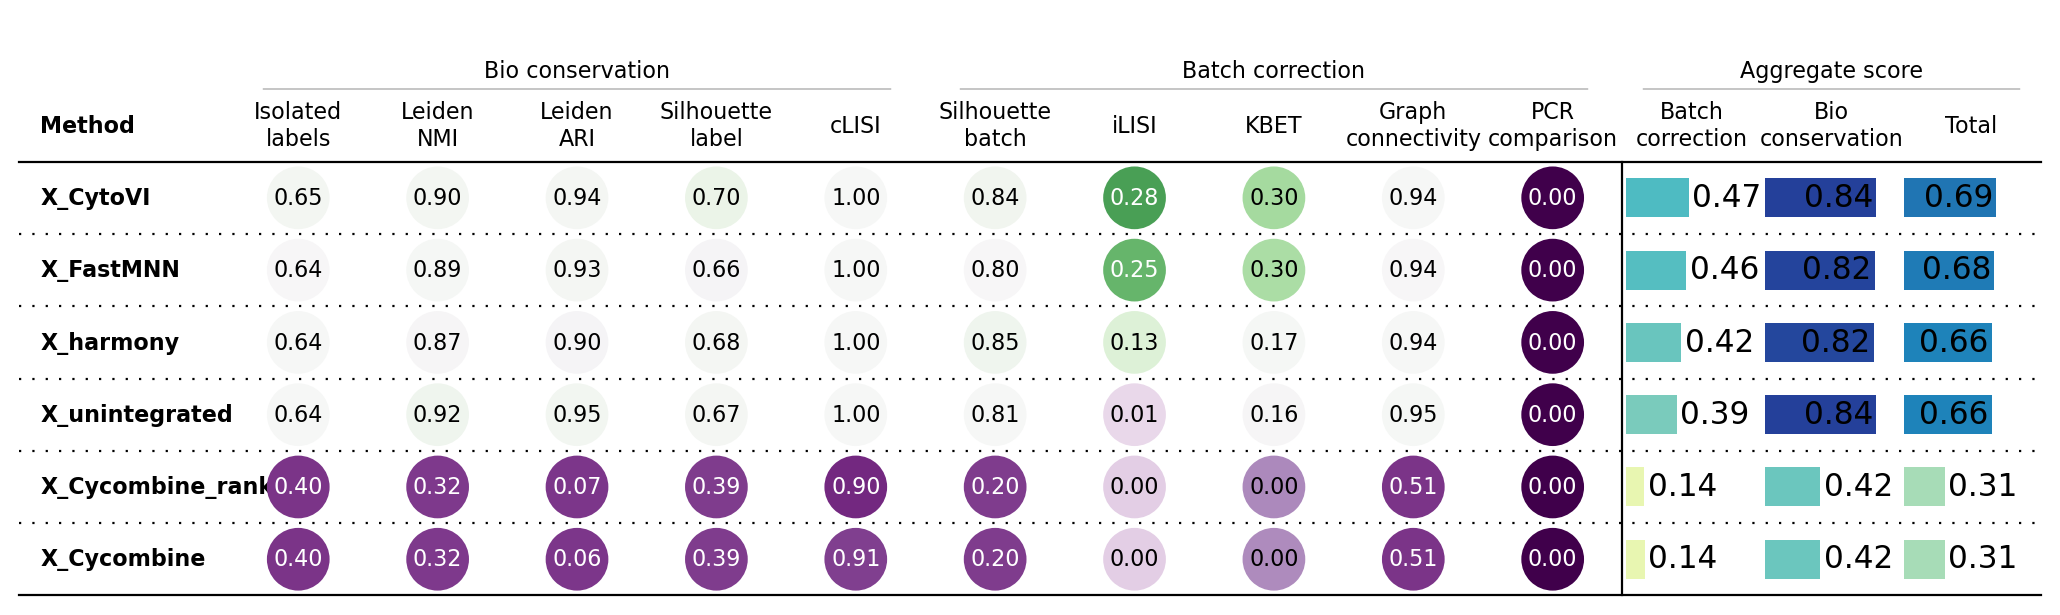

In [70]:
bm.plot_results_table(min_max_scale = False, show = False)

In [18]:
# save bm results as csv
bm.get_results(min_max_scale=False).to_csv(f'{model_path}/2025-08-21_Levine_Stuart_combined_benchmarking_results.csv')

In [19]:
# read again and do costumn plotting
bm_res = pd.read_csv(f'{model_path}/2025-08-21_Levine_Stuart_combined_benchmarking_results.csv', index_col = 0)
bm_res.rename(index = {'X_CytoVI': 'X_CytoVI_zscore', 
                       'X_FastMNN': 'X_FastMNN_zscore', 
                       'X_harmony': 'X_harmony_zscore', 
                       'X_unintegrated': 'X_unintegrated_zscore',
                       'X_Cycombine': 'X_Cycombine_zscore'
                    }, inplace=True)

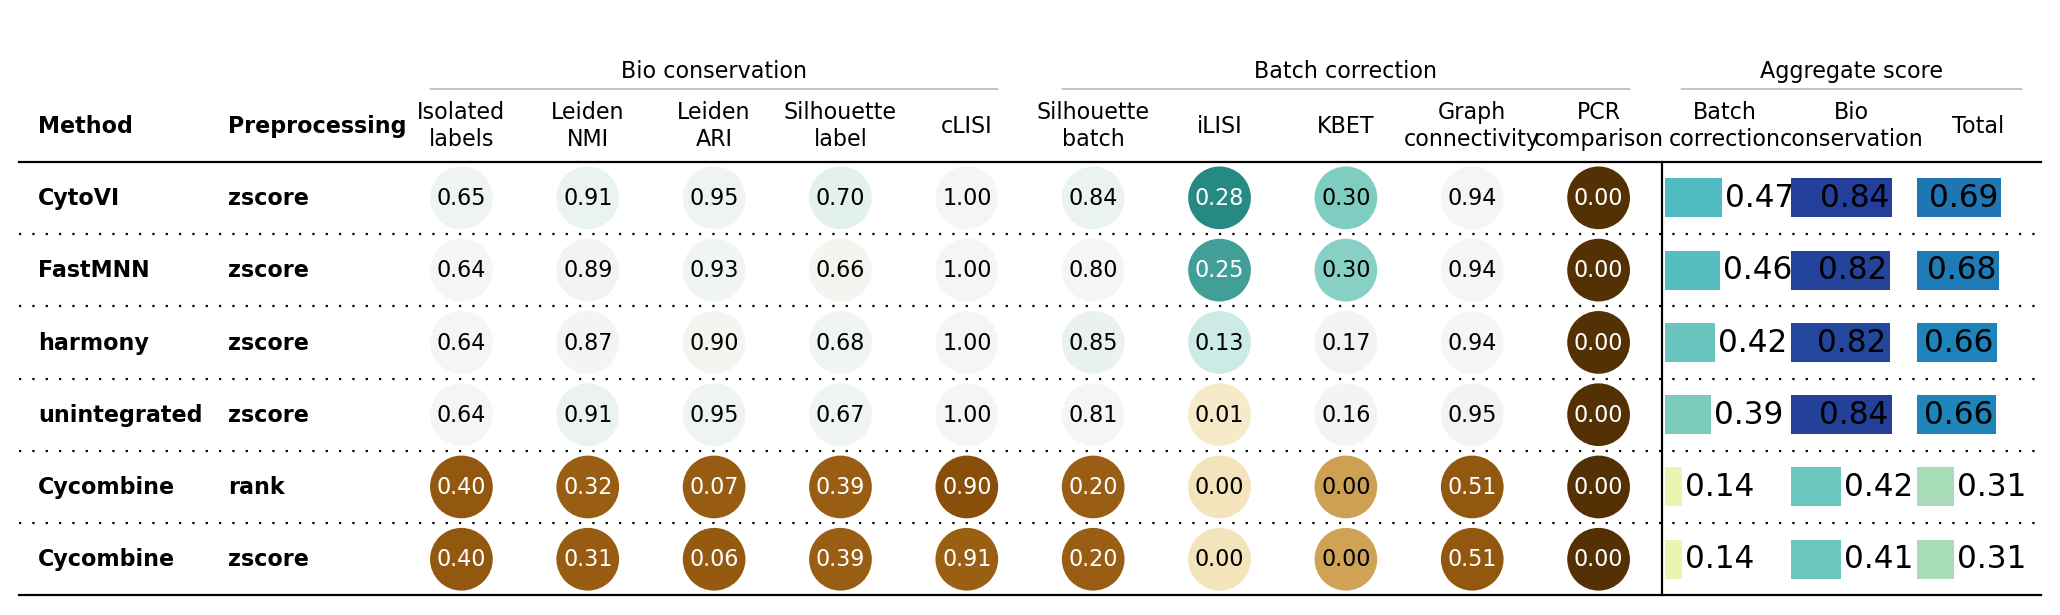

In [20]:
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
import matplotlib.pyplot as plt
import numpy as np

cmap_fn = lambda col_data: normed_cmap(col_data, cmap=plt.cm.BrBG, num_stds=2.5)

# Drop 'Metric Type' from the DataFrame
plot_df = bm_res.drop('Metric Type', axis=0)
num_embeds = plot_df.shape[0]

# Sort by total score
plot_df = plot_df.sort_values(by="Total", ascending=False).astype(np.float64)
plot_df["Method"] = plot_df.index

# Split the Method column into two columns, filling missing parts with empty strings
split_methods = plot_df['Method'].str.split('_', n=2, expand=True)
plot_df['Method'] = split_methods[1]
plot_df['Preprocessing'] = split_methods[2]
# plot_df['Method_Part2'] = split_methods[1].fillna('')

# Rearrange the columns to put the new Method_Part1 and Method_Part2 columns at the beginning
cols = ['Method', 'Preprocessing'] + [col for col in plot_df.columns if col not in ['Method', 'Preprocessing']]
plot_df = plot_df[cols]

# plot_df = plot_df.drop(columns=['Method'])

# Split columns by metric type
score_cols = bm_res.columns[bm_res.loc['Metric Type'] == 'Aggregate score']
other_cols = bm_res.columns[bm_res.loc['Metric Type'] != 'Aggregate score']
other_cols = [col for col in other_cols if col != 'New_col']

column_definitions = [
    ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
    ColumnDefinition("Preprocessing", width=1.5, textprops={"ha": "left", "weight": "bold"}),
]

# Circles for the metric values
column_definitions += [
    ColumnDefinition(
        col,
        title=col.replace(" ", "\n", 1),
        width=1,
        textprops={
            "ha": "center",
            "bbox": {"boxstyle": "circle", "pad": 0.25},
        },
        cmap=cmap_fn(plot_df[col]),
        group=bm_res.loc['Metric Type', col],
        formatter="{:.2f}",
    )
    for i, col in enumerate(other_cols)
]

# Bars for the aggregate scores
column_definitions += [
    ColumnDefinition(
        col,
        width=1,
        title=col.replace(" ", "\n", 1),
        plot_fn=bar,
        plot_kw={
            "cmap": plt.cm.YlGnBu,
            "plot_bg_bar": False,
            "annotate": True,
            "height": 0.9,
            "formatter": "{:.2f}",
        },
        group=bm_res.loc['Metric Type', col],
        border="left" if i == 0 else None,
    )
    for i, col in enumerate(score_cols)
]

# Allow to manipulate text post-hoc (in illustrator)
size = 1

with plt.rc_context({"svg.fonttype": "none"}):
    fig, ax = plt.subplots(figsize=(len(bm_res.columns) * 1.25 * size, 3 + 0.3 * num_embeds * size))
    tab = Table(
        plot_df,
        cell_kw={
            "linewidth": 0,
            "edgecolor": "k",
        },
        column_definitions=column_definitions,
        ax=ax,
        row_dividers=True,
        footer_divider=True,
        textprops={"fontsize": 10, "ha": "center"},
        row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
        col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
        column_border_kw={"linewidth": 1, "linestyle": "-"},
        index_col='Method', 
    ).autoset_fontcolors(colnames=plot_df.columns)

plt.show()
fig.savefig(os.path.join(figure_dir, "scib_results_cross_int.pdf"), facecolor=ax.get_facecolor(), dpi=300)

## Add random noise

In [90]:
sigma_range = (0.1, 0.2, 0.5, 1, 2)

for sigma in sigma_range:
    noise = np.random.normal(0, sigma, adata.shape)
    adata.layers[f'std_scaled_{sigma}'] = adata.layers['std_scaled'] + noise
    adata.layers[f'std_scaled_{sigma}'] = adata.layers[f'std_scaled_{sigma}'] * adata.layers['_nan_mask']

In [92]:
# save anndata
adata.write(f'{model_path}/2025-08-21_Levine_Stuart_combined_adata_all_methods_noise_added.h5ad')

In [94]:
adata

AnnData object with n_obs × n_vars = 62393 × 45
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'harmonized_labels', 'file_number', 'event_number', 'label', 'individual', 'population', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_sample_id'
    var: '_batch_0', '_batch_1'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'neighbors', 'umap', 'harmonized_labels_colors', 'batch_colors'
    obsm: 'X_CytoVI', 'X_harmony', 'X_FastMNN', 'X_Cycombine', 'X_Cycombine_rank', 'X_unintegrated', 'X_umap', 'X_umap_CytoVI', 'X_umap_harmony', 'X_umap_FastMNN', 'X_umap_Cycombine', 'X_umap_Cycombine_rank', 'X_umap_unintegrated', 'X_umap_umap'
    layers: '_nan_mask', 'raw', 'scaled', 'std_scaled', 'transformed', 'std_scaled_0.1', 'std_scaled_0.2', 'std_scaled_0.5', 'std_scaled_1', 'std_scaled_2'
    obsp: 'distances', 'connectivities'

In [96]:
# save the noise models as csv
noise_model_path = '/home/projects/amit/floriani/Lab/PROJECTS/FlowVI/models/cross_tech_int/2025-08-20_Levine_Stuart/2025-08-21_Noise_benchmarking'

adata_bb = adata[:, bb_markers].copy()

for sigma in sigma_range:
    adata_str = f'2025-08-21_Levine_Stuart_combined_adata_all_methods_noise_added_sigma_{sigma}'

    layer_key = f'std_scaled_{sigma}'

    expr = pd.DataFrame(adata_bb.layers[layer_key], columns=adata_bb.var_names)
    expr.to_csv(f'{noise_model_path}/{adata_str}_expr.csv')

In [12]:
# read the adata with CytoVI and Harmony embeddings
adata = ad.read_h5ad(f'{noise_model_path}/2025-08-21_Levine_Stuart_combined_adata_all_methods_noise_added_CytoVI_Harmony.h5ad')

In [22]:
# add embeddings from FastMNN
for sigma in sigma_range:
    adata.obsm[f'X_FastMNN_{sigma}'] = pd.read_csv(f'{noise_model_path}/2025-08-21_Levine_Stuart_combined_adata_all_methods_noise_added_sigma_{sigma}_embd_fastmnn.csv').to_numpy()
    adata.obsm[f'X_unintegrated_{sigma}'] = adata_bb.layers[f'std_scaled_{sigma}'].copy()

In [24]:
# save to disk
adata.write(f'{noise_model_path}/2025-08-22_Levine_Stuart_combined_adata_all_methods_noise_added_all_methods.h5ad')

In [27]:
# perform scib
latent_obsm_keys = [key for key in adata.obsm.keys() if key.startswith('X_CytoVI') or key.startswith('X_harmony') or key.startswith('X_FastMNN') or key.startswith('X_unintegrated')]

adata_bm = adata[adata.obs['harmonized_labels'] != 'Unknown', bb_markers].copy()
adata_bm.obs['harmonized_labels'].cat.remove_unused_categories()

adata_bm = cytovi.pp.subsample(adata_bm, n_obs = 20000, groupby = 'batch').copy()
adata_bm.X = adata_bm.layers['std_scaled'].copy()

/home/projects/amit/floriani/github_repos/CytoVI_dev/src/cytovi/pp/cyto_pp.py:355: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  index = adata.obs.groupby(groupby, as_index=False).apply(


In [ ]:
# perform the actual benchmarking
from scib_metrics.benchmark import Benchmarker, BioConservation

biocon = BioConservation(nmi_ari_cluster_labels_leiden = True, nmi_ari_cluster_labels_kmeans = False)

bm = Benchmarker(
    adata_bm,
    batch_key="batch",
    label_key="harmonized_labels",
    embedding_obsm_keys=latent_obsm_keys,
    pre_integrated_embedding_obsm_key='X_unintegrated',
    bio_conservation_metrics = biocon,
    n_jobs=40,
)
bm.benchmark()

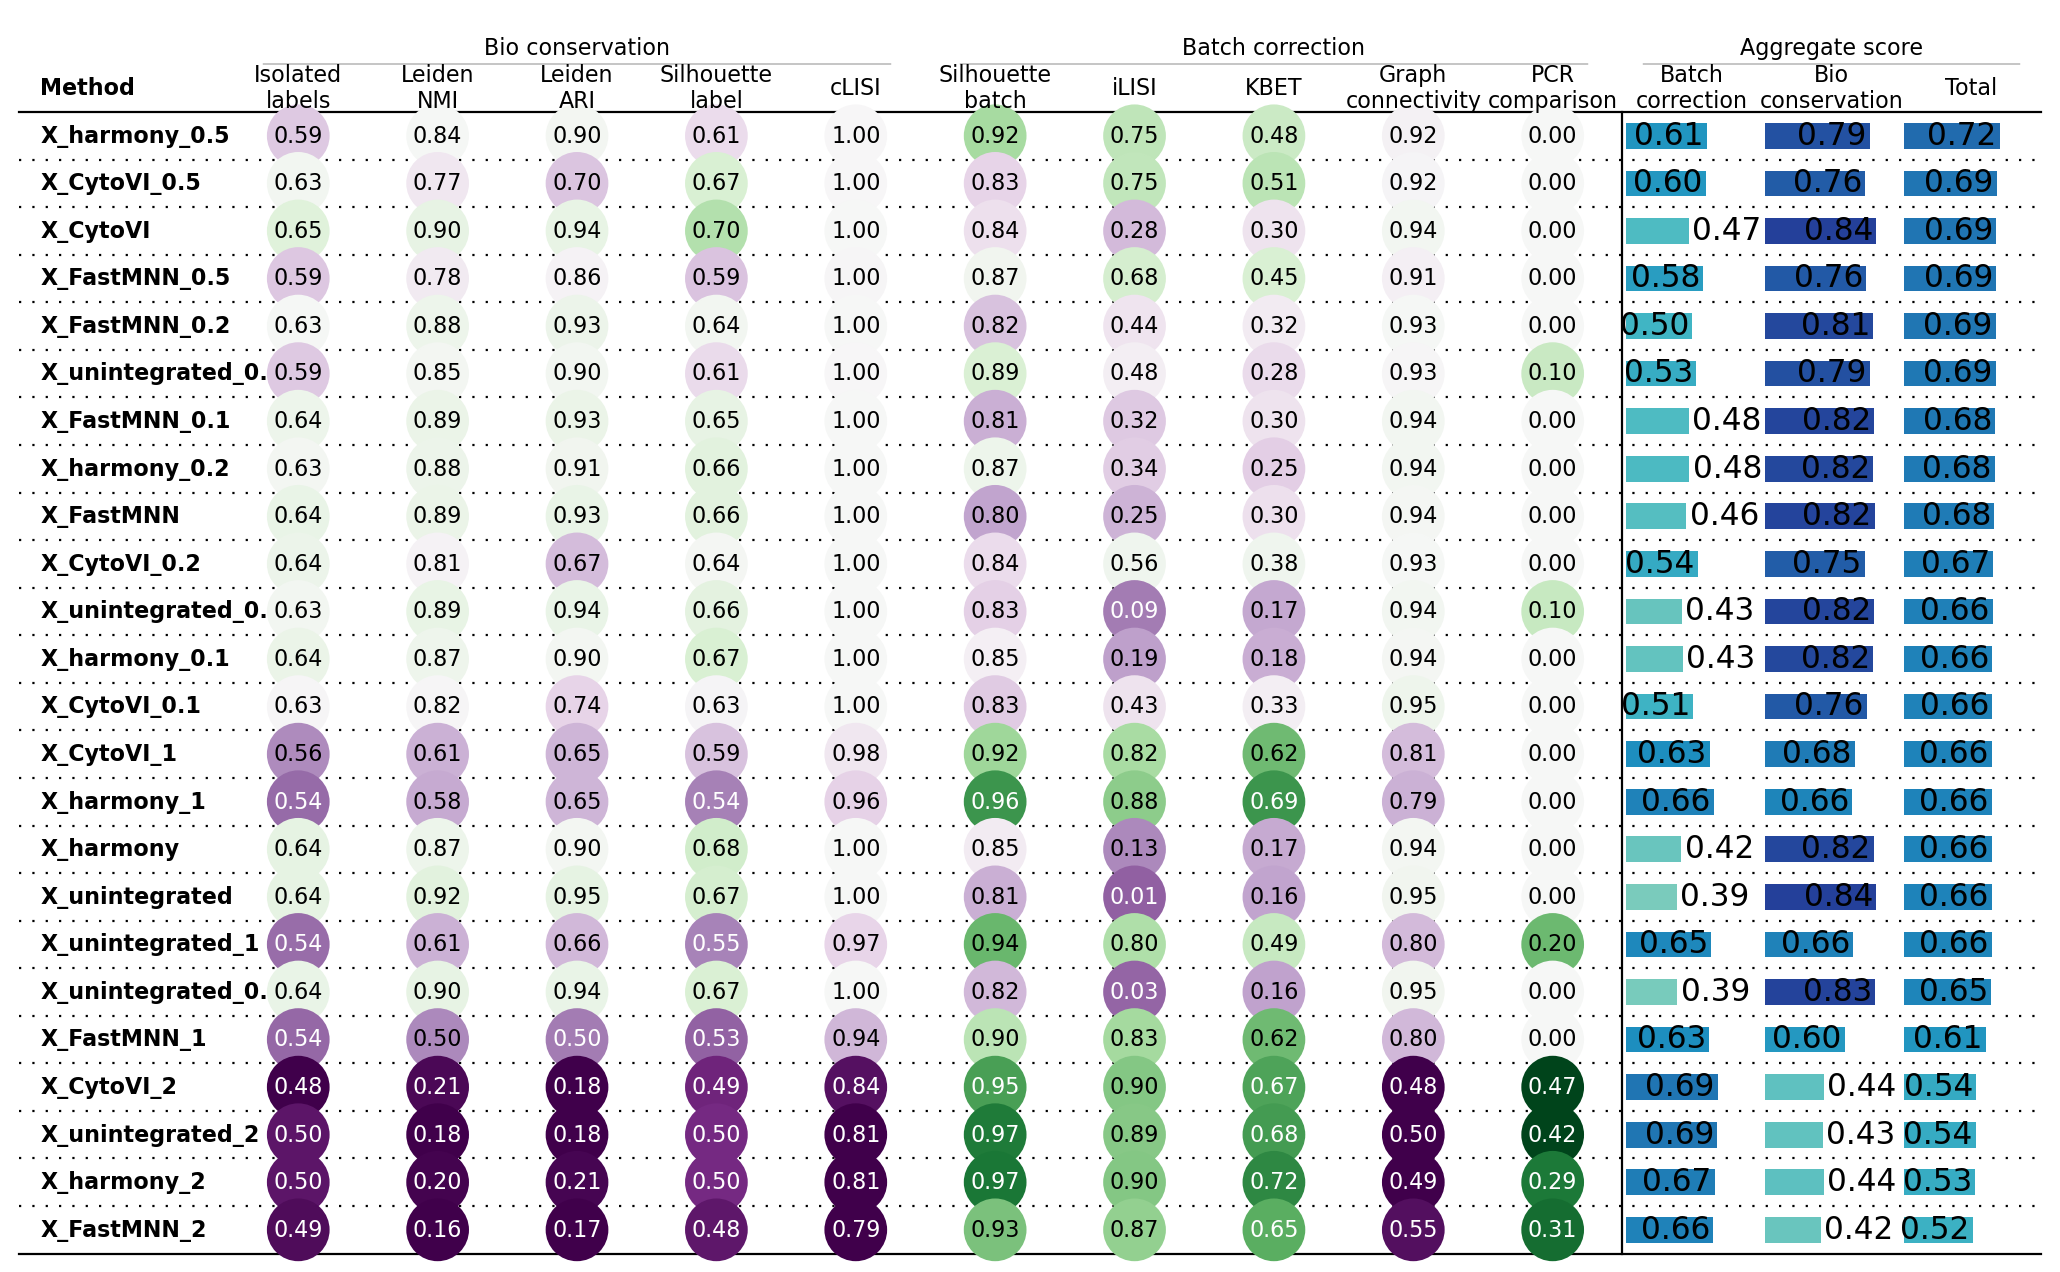

In [29]:
bm.plot_results_table(min_max_scale = False, show = False)

In [30]:
# save bm results as csv
bm.get_results(min_max_scale=False).to_csv(f'{noise_model_path}/2025-08-22_Levine_Stuart_combined_benchmarking_results_noise.csv')

In [45]:
# read again and do costumn plotting
bm_res = pd.read_csv(f'{noise_model_path}/2025-08-22_Levine_Stuart_combined_benchmarking_results_noise.csv', index_col = 0)
bm_res.rename(index = {'X_CytoVI': 'X_CytoVI_0', 
                       'X_FastMNN': 'X_FastMNN_0', 
                       'X_harmony': 'X_harmony_0', 
                       'X_unintegrated': 'X_unintegrated_0'
                    }, inplace=True)

bm_res = bm_res.iloc[0:-1,:].copy()

bm_res['Total'] = bm_res['Total'].astype('float64')
bm_res['Bio conservation'] = bm_res['Bio conservation'].astype('float64')
bm_res['Batch correction'] = bm_res['Batch correction'].astype('float64')

In [46]:
bm_res['Method'] = bm_res.index.str.split('_').str[1]
bm_res['Noise'] = bm_res.index.str.split('_').str[2].fillna('0')

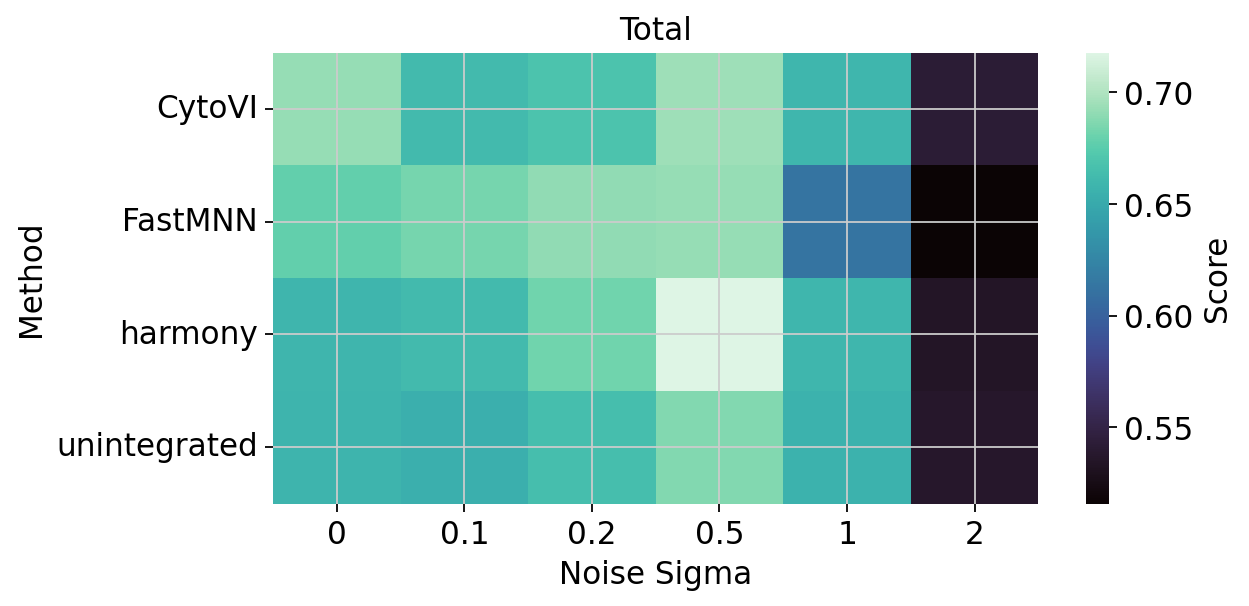

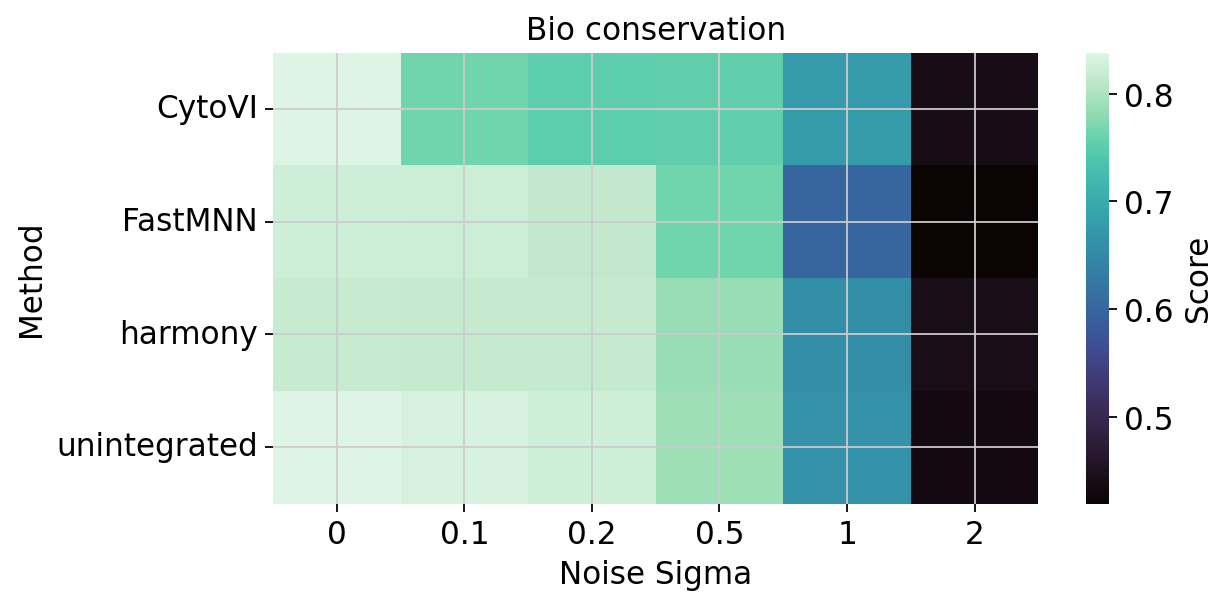

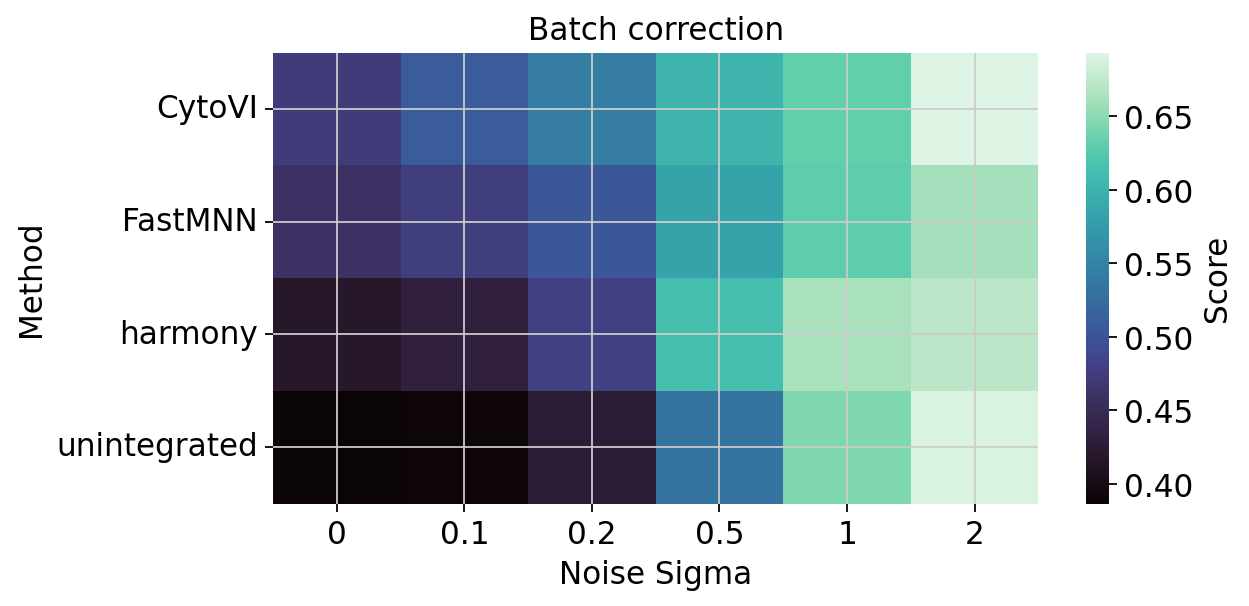

In [51]:
# Pivot into matrix form (rows = nhidden, cols = nlatent)
scores = ['Total', 'Bio conservation', 'Batch correction']

for score in scores:
    heatmap_data = bm_res.pivot(index="Method", columns="Noise", values=score)

    plt.figure(figsize=(8,4))
    sns.heatmap(
        heatmap_data,
        fmt=".1f",          # format numbers
        cmap="mako",      # same palette you used
        cbar_kws={"label": "Score"}
    )

    plt.title(score)
    plt.ylabel("Method")
    plt.xlabel("Noise Sigma")

    plt.tight_layout()
    plt.savefig(f'{figure_dir}/Heatmap_noise_nunez{score}.pdf', bbox_inches='tight')
    plt.show()

## Cell type masking

In [4]:
adata = ad.read_h5ad(f'{model_path}/2025-08-21_Levine_Stuart_combined_adata_all_methods.h5ad')
adata

AnnData object with n_obs × n_vars = 62393 × 45
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'lane', 'donor', 'celltype.l1', 'celltype.l2', 'RNA.weight', 'harmonized_labels', 'file_number', 'event_number', 'label', 'individual', 'population', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_sample_id'
    var: '_batch_0', '_batch_1'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'batch_colors', 'harmonized_labels_colors', 'neighbors', 'umap'
    obsm: 'X_Cycombine', 'X_Cycombine_rank', 'X_CytoVI', 'X_FastMNN', 'X_harmony', 'X_umap', 'X_umap_Cycombine', 'X_umap_Cycombine_rank', 'X_umap_CytoVI', 'X_umap_FastMNN', 'X_umap_harmony', 'X_umap_umap', 'X_umap_unintegrated', 'X_unintegrated'
    layers: '_nan_mask', 'raw', 'scaled', 'std_scaled', 'transformed'
    obsp: 'connectivities', 'distances'

In [130]:
ct_model_path = f'{model_path}/2025-08-22_Celltype_ablation'

for ct in adata.obs['harmonized_labels'].cat.categories:
    if ct != 'Unknown':
        # mask ct from one batch
        mask_inds = adata[(adata.obs['harmonized_labels'] == ct) & (adata.obs['batch']=='0')].obs_names
        adata_ct = adata[~adata.obs_names.isin(mask_inds),:].copy()

        # save adata
        adata_ct.write(f'{ct_model_path}/2025-08-22_Levine_Stuart_combined_adata_{ct}_ablation.h5ad')

        # save obs and expr
        save_adata_as_csv(adata_ct[:, bb_markers], ct_model_path, f'2025-08-22_Levine_Stuart_combined_adata_{ct}_ablation.h5ad', 'std_scaled')


In [131]:
# add FastMNN embeddings
for ct in adata.obs['harmonized_labels'].cat.categories:
    if ct != 'Unknown':
        embd = pd.read_csv(f'{ct_model_path}/2025-08-25_Levine_Stuart_combined_adata_{ct}_ablation_embd.csv')
        adata_ct = ad.read_h5ad(f'{ct_model_path}/2025-08-22_Levine_Stuart_combined_adata_{ct}_ablation_CytoVI_Harmony.h5ad')
        adata_ct.obsm['X_FastMNN'] = embd.to_numpy()
        adata_ct.write(f'{ct_model_path}/2025-08-25_Levine_Stuart_combined_adata_{ct}_ablation_CytoVI_Harmony_FastMNN.h5ad')

In [132]:
embeddings = ['X_unintegrated', 'X_harmony', 'X_CytoVI', 'X_FastMNN']

res_df = []
for ct in adata.obs['harmonized_labels'].cat.categories:
    if ct != 'Unknown':
        print(f'Processing cell type ablation for {ct}')
        adata_ct = ad.read_h5ad(f'{ct_model_path}/2025-08-25_Levine_Stuart_combined_adata_{ct}_ablation_CytoVI_Harmony_FastMNN.h5ad')

        df = evaluate_integration_scib_ilisi(
            adata_ct, embeddings,
            batch_col='batch',
            ct_col='harmonized_labels',
            unint_key='X_unintegrated',
            k_leak=30, k_ilisi=30
        )
        res_df.append(df)

res_comb = pd.concat(res_df, ignore_index=True)

Processing cell type ablation for B_cell_mature


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


Processing cell type ablation for B_cell_progenitor


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


Processing cell type ablation for HSC


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


Processing cell type ablation for HSPC


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


Processing cell type ablation for Monocytes


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


Processing cell type ablation for NK


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


Processing cell type ablation for Plasma_B


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


Processing cell type ablation for T_CD4


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


Processing cell type ablation for T_CD8


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


Processing cell type ablation for pDC


/tmp/ipykernel_12396/1790586064.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = obs.groupby([ct_col, batch_col]).size().unstack(fill_value=0)


In [133]:
# save to disk
res_comb.to_csv(f'{ct_model_path}/2025-08-25_Levine_Stuart_combined_celltype_ablation_scib_results.csv')

In [4]:
# read again
res_comb = pd.read_csv(f'{ct_model_path}/2025-08-25_Levine_Stuart_combined_celltype_ablation_scib_results.csv')

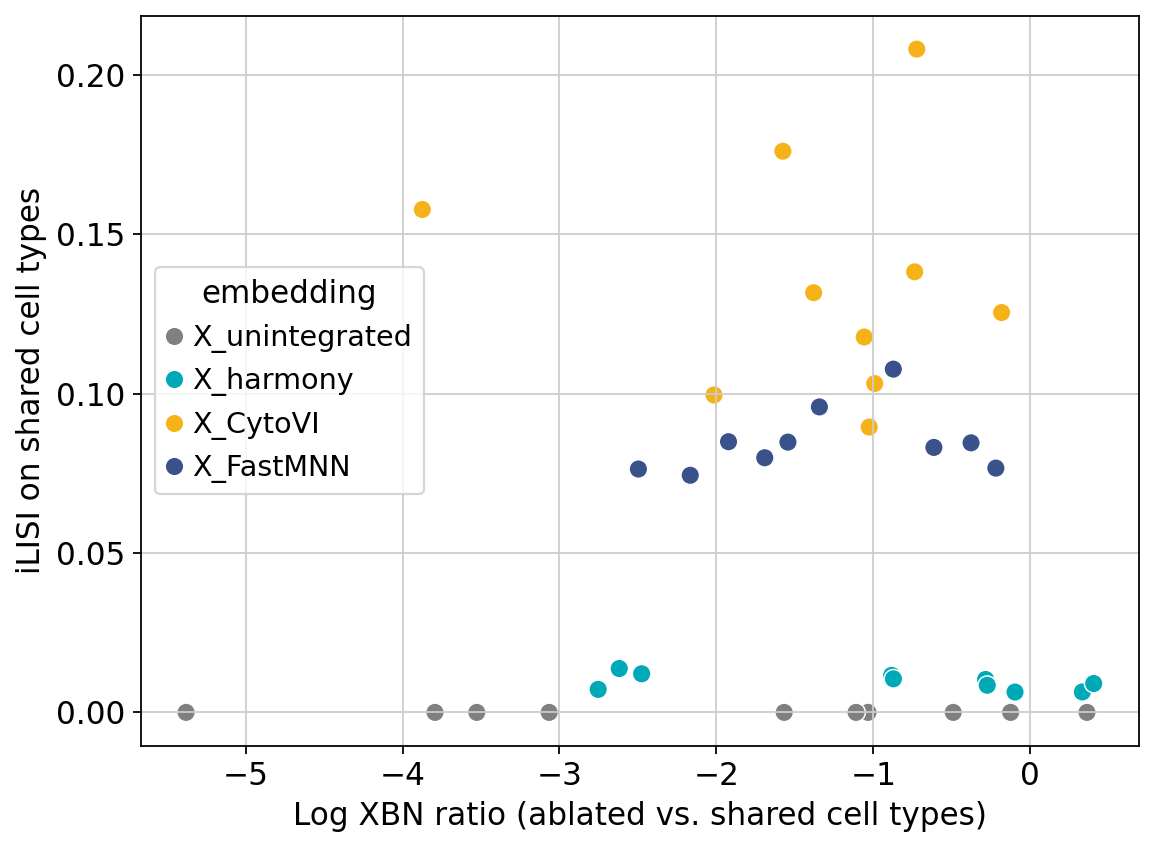

In [135]:
# plot results
palette = {'X_CytoVI': '#F6B319',
            'X_harmony': '#00A9B8',
            'X_FastMNN':  '#3A528B',
             'X_unintegrated': 'grey'}

plt.figure(figsize=(8, 6))
sns.scatterplot(data=res_comb,x='XBN_logratio', y='iLISI_shared_scaled', hue='embedding', palette=palette, s= 70)

plt.xlabel('Log XBN ratio (ablated vs. shared cell types)')
plt.ylabel('iLISI on shared cell types')
plt.savefig(f'{figure_dir}Scatterplot_Nunez_Celltype ablation_CytoVI_Harmony_FastMNN.pdf')

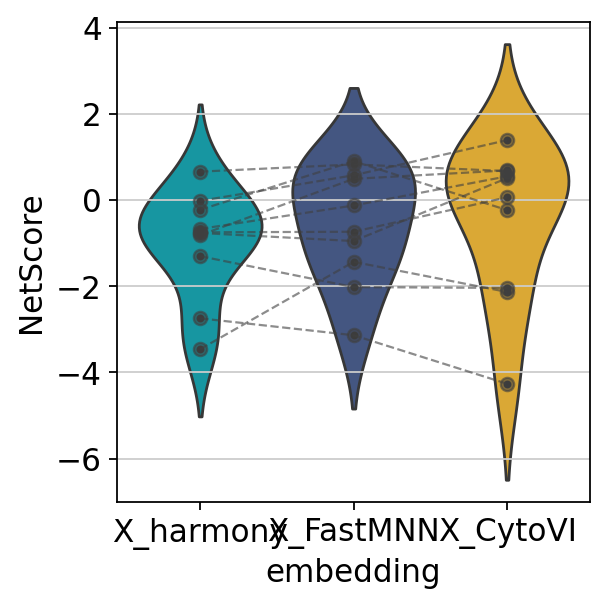

In [147]:
embedding_order = ['X_harmony', 'X_FastMNN', 'X_CytoVI']


ax = sns.violinplot(
    data=res_comb[res_comb['embedding'] != 'X_unintegrated'],
    x='embedding', y='NetScore',
    inner='point', hue='embedding',
    palette=palette, dodge=False,
    order=embedding_order
)


tmp = (res_comb[res_comb['embedding'] != 'X_unintegrated']
       .groupby(['missing_ct','embedding'], as_index=False)['NetScore']
       .mean())


wide = (tmp.pivot(index='missing_ct', columns='embedding', values='NetScore')
           .reindex(columns=embedding_order))

# add dashed lines
for ct, y in wide.dropna().iterrows():
    ax.plot(embedding_order, y.values,
            linestyle='--', marker='o', lw=1, alpha=0.6, color='0.25', zorder=3)

plt.tight_layout()
plt.savefig(f'{figure_dir}Violinplot_Nunez_Celltype_ablation_CytoVI_Harmony_FastMNN.pdf')


/home/projects/amit/floriani/mambaforge/envs/cytovi_gpu/lib/python3.12/site-packages/anndata/__init__.py:42: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


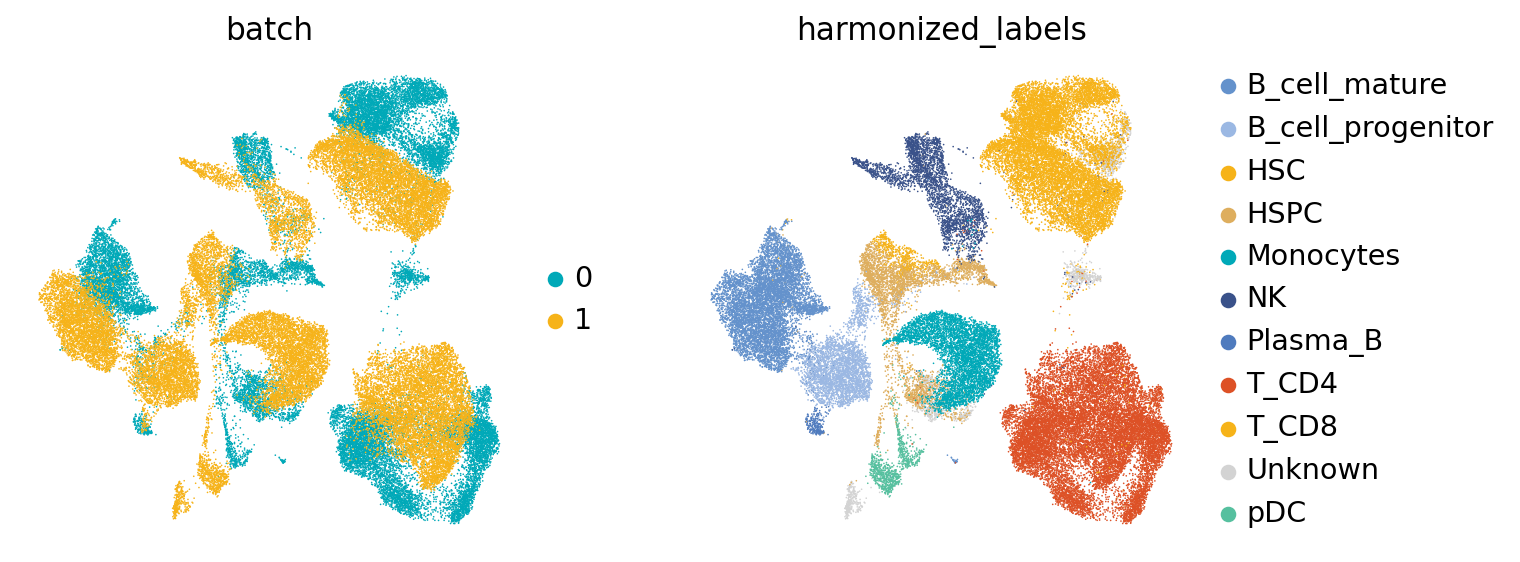

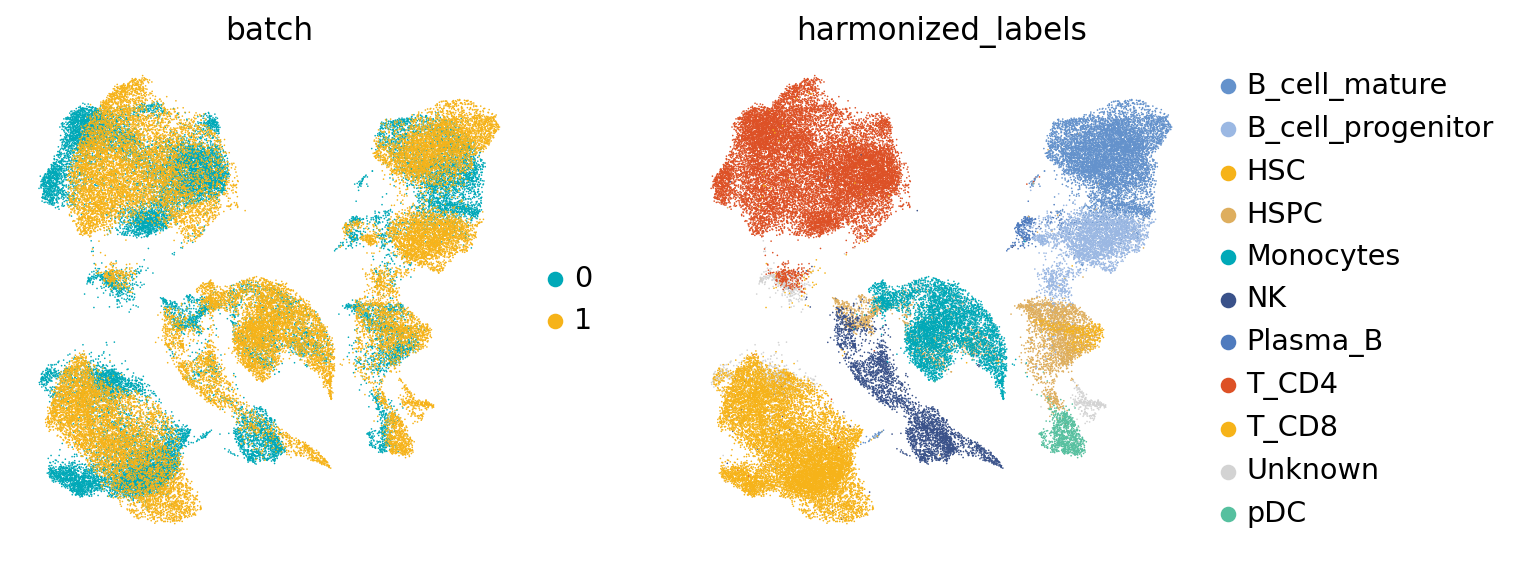

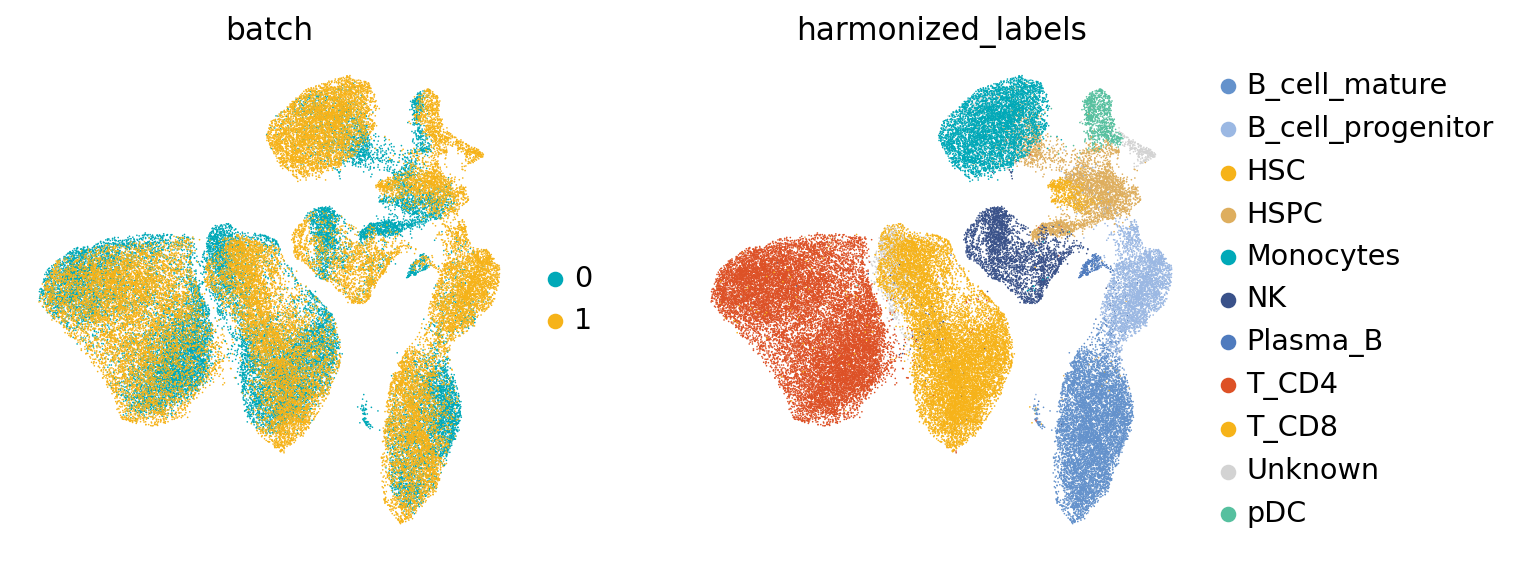

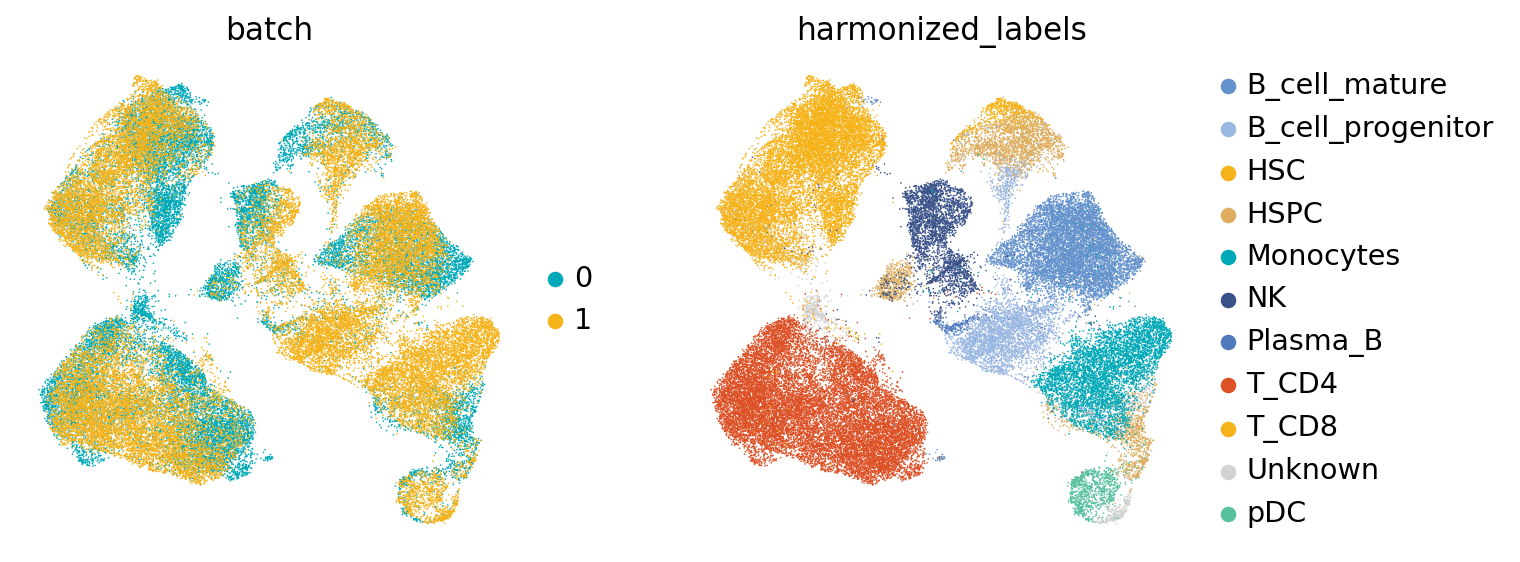

In [13]:
# load embeddings for exemplary cell types
ct = 'Monocytes'
adata_ct = ad.read(f'{ct_model_path}/2025-08-25_Levine_Stuart_combined_adata_{ct}_ablation_CytoVI_Harmony_FastMNN.h5ad')

for key in embeddings:
    sc.pp.neighbors(adata_ct, use_rep=key)
    sc.tl.umap(adata_ct)
    sc.pl.umap(adata_ct, color = ['batch', 'harmonized_labels'], frameon=False, save = f'Cell_type_ablation_embedding_{ct}_{key[2:]}.png')